In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

C:\Users\Connie\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Connie\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Connie\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pd.read_csv("review_data.csv").head()

,score,review,y
0,5,新鮮でおいしいです。,1
1,4,녹는다 녹아,1
2,4,좋아요,1
3,5,흠잡을곳 없는 반찬이 정갈합니다,1
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1


In [3]:
df = pd.read_csv("review_data.csv")

In [4]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [5]:
# 함수를 적용하여 리뷰에서 한글만 추출
df = pd.read_csv("review_data.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
1,4,1,녹는다 녹아
2,4,1,좋아요
3,5,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...
5,5,1,살치살 미쳤네요 대박입니다 퀄리티 굳이에요


In [6]:
# Jupyter Notebook에서의 타임아웃 설정
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
'''Okt : 형태소 단위 추출'''


from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt() # 형태소 분석 초기화
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]#각 형태소와 품사를 문자열로 조합
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

'Okt : 형태소 단위 추출'

['녹는다/Verb', '녹아/Verb']


In [8]:
df['ko_text'][1]
'''원래는 이런 모양 '''

'녹는다 녹아'

'원래는 이런 모양 '

### 분류 모델의 학습 데이터로 변환

In [9]:
#corpus index 생성하기
#df['ko_text'].tolist() -  이 형태는 말뭉치 형태 -- 이것을 백터화
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
'''토크나이져를 해줘야 의미 단위로 문자를 분리 해준다 그렇지 않으면 띄어쓰기
위주로만 단어를 분리 한다'''
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

'토크나이져를 해줘야 의미 단위로 문자를 분리 해준다 그렇지 않으면 띄어쓰기\n위주로만 단어를 분리 한다'

In [10]:
X.shape

(370, 2355)

In [11]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'녹는다/Verb': 443, '녹아/Verb': 444, '좋아요/Adjective': 1900, '흠잡을/Adjective': 2346, '곳/Noun': 191, '없는/A..


In [12]:
print(df['ko_text'].values[0])
print(X[0])

녹는다 녹아
  (0, 443)	1
  (0, 444)	1


### 긍정 부정 리뷰 분류하기

In [13]:
# 데이터 분리 셋
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)


(259, 2355)
(111, 2355)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

LogisticRegression(random_state=0)

accuracy: 0.79
Precision : 0.773
Recall : 0.906
F1 : 0.835


In [15]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[30 17]
 [ 6 58]]


AUC : 0.851


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve of Logistic regression')

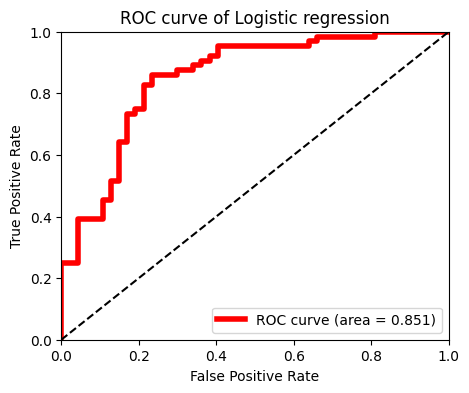

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

In [17]:
'''클래스 균형 맞춰주기'''
df['y'].tolist() # 1 이 너무 많은 결과가 나온다 불균형한 모습 
# 1:1 비율로 랜덤 샘플링을 실행 한다 
df[df['y']==1].sample(50) #값이 1인것 랜덤으로 50개만 가져온다
positive_random_idx=df[df['y']==1].sample(50, random_state =30).index.tolist()
negative_random_idx=df[df['y']==0].sample(50, random_state =30).index.tolist()
# 출력결과 확인 positive_random_idx ,negative_random_idx

'클래스 균형 맞춰주기'

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,


,score,y,ko_text
312,4,1,한우된장찌개 괜찮아요
139,5,1,존맛탱 가성비갑
12,5,1,강남 회식장소로 제격 깔끔한 내부 깔끔한 고기 냉면 일품이네요 가장좋은건 회식할 때...
324,5,1,고기도 구워주고 명이나물에 싸먹으면 진짜 존맛
188,5,1,친절하고 맛있고 강남에 곱창집중 제일 나은듯
325,5,1,삼겹살을 다 구워주시고 특히 꽃삼겹살은 마치 소고기 차돌박이 같은 얇음 꼭 드셔보세요
315,5,1,맛있게먹었다 융숭한대접에감사한다
356,4,1,맛있음 근데 너무 시끄럽다 ㅠㅠㅠ
300,5,1,가족들이랑 오랫만에 맛있는 음식 먹었네요 다음에 또 방문할 의향 있어요
257,5,1,끝내줌 차돌박이 존맛 두배는 두꺼운듯


In [27]:
# 두인덱스를 합하면 
random_idx = positive_random_idx + negative_random_idx
 #random_idx

import numpy as np
from sklearn.model_selection import train_test_split


# random_idx 생성 (예시로 100개의 샘플을 무작위로 선택)
random_idx = np.random.choice(X.shape[0], size=100, replace=False)

sample_X = X[random_idx, :]
y = df['y'][random_idx]

x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.03, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(97, 2355)
(97,)
(3, 2355)
(3,)


In [20]:
'''Logic Regression  다시 실행 '''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

'Logic Regression  다시 실행 '

LogisticRegression(random_state=0)

accuracy: 0.67
Precision : 1.000
Recall : 0.667
F1 : 0.800


In [21]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[0 0]
 [1 2]]


AUC: 1.000


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve of Logistic regression')

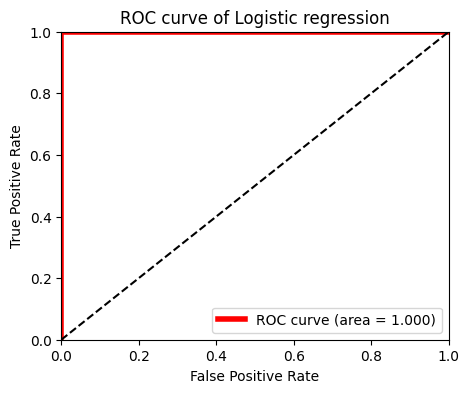

In [30]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt



# # AUC를 계산합니다.
# from sklearn.metrics import roc_curve, roc_auc_score

# # 로지스틱 회귀 모델의 예측 확률을 얻어옴
# y_pred_probability = lr.predict_proba(x_test)[:, 1]

# # AUC를 계산합니다.
# roc_auc = roc_auc_score(y_test, y_pred_probability)
# print("AUC: %.3f" % roc_auc)


# # ROC curve 그래프를 출력합니다.
# plt.rcParams['figure.figsize'] = [5, 4]
# plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
#          color='red', linewidth=4.0)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 로지스틱 회귀 모델의 예측 확률을 얻어옴
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# AUC를 계산합니다.
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC: %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")
plt.show()


### 회귀 모델의 피처 영항력 추출

<BarContainer object of 2355 artists>

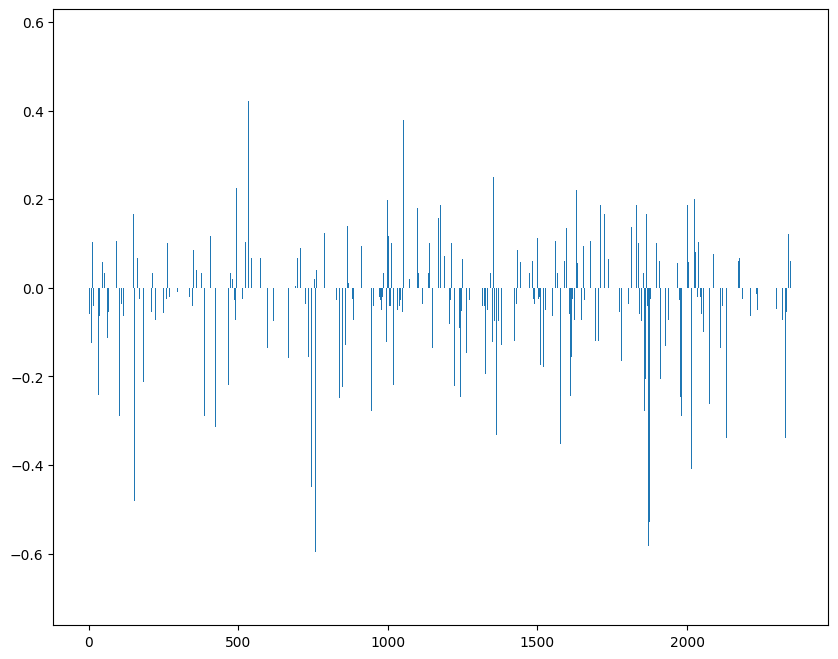

In [31]:
# 학습한 회귀 모델의 계수 추출
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [32]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])
'''결과를 보고 몇번째 단어가 긍정적인 또는 부정적인 효과에 영향을 미쳤다는 것을 알 수 있다'''

[(0.565614369532718, 763), (0.518496373359536, 1545), (0.49179034090024765, 1691), (0.49179034090024765, 1011), (0.45740025357743186, 753)]
[(-0.5278791520042896, 1652), (-0.58237725512191, 1871), (-0.5857409911307144, 1900), (-0.5953894535868327, 758), (-0.6986842963878755, 1739)]


'결과를 보고 몇번째 단어가 긍정적인 또는 부정적인 효과에 영향을 미쳤다는 것을 알 수 있다'

In [33]:
# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [34]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력/ 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소
print(str(invert_index_vectorizer)[:100]+'..')

{443: '녹는다/Verb', 444: '녹아/Verb', 1900: '좋아요/Adjective', 2346: '흠잡을/Adjective', 191: '곳/Noun', 1483:..


In [35]:
# 상위 20개 긍정 형태소
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    

맛있어요/Adjective 0.565614369532718
예요/Josa 0.518496373359536
이에요/Josa 0.49179034090024765
보통/Noun 0.49179034090024765
맛있는데/Adjective 0.45740025357743186
가/Josa 0.446091619868574
대창/Noun 0.4217062515781572
분들/Suffix 0.3790752585034096
삼겹살/Noun 0.3607862080237874
깔끔해서/Adjective 0.3158326710301467
맛집/Noun 0.2817678685046983
맛있음/Adjective 0.2813059414716284
요/Noun 0.2799652275262058
거기/Noun 0.2758364413024726
에/Josa 0.2662443236448961
좋습니다/Adjective 0.2647897917461953
비는/Verb 0.2628173919540522
아쉬웠어요/Adjective 0.25117808824155724
냉면/Noun 0.25117808824155724
일산/Noun 0.24482575522493333


In [36]:
# 상위 20개 부정 형태소
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

먹기/Noun -0.36807395458019015
들/Suffix -0.37162421679601043
못/VerbPrefix -0.37889430489564285
을/Josa -0.38114164721868604
좋음/Adjective -0.4053992812134804
창고/Noun -0.4089159609570004
그닥/Noun -0.41417498155696675
해줌/Verb -0.4357869533401396
편하게/Adjective -0.4357869533401396
맛있고/Adjective -0.45014353704145565
하기에/Verb -0.46450626602806216
것/Noun -0.4820209838345209
아쉬워요/Adjective -0.49068746613842296
그/Determiner -0.506993370376486
조금/Noun -0.5277604584697854
이/Josa -0.5278791520042896
제일/Noun -0.58237725512191
좋아요/Adjective -0.5857409911307144
맛있댜/Noun -0.5953894535868327
입니다/Adjective -0.6986842963878755


In [37]:
# 형용사 명사 리스트 출력
noun_list = []
adjective_list = []


for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [38]:
noun_list[:10]

[('보통/Noun', 0.49179034090024765),
 ('대창/Noun', 0.4217062515781572),
 ('삼겹살/Noun', 0.3607862080237874),
 ('맛집/Noun', 0.2817678685046983),
 ('요/Noun', 0.2799652275262058),
 ('거기/Noun', 0.2758364413024726),
 ('냉면/Noun', 0.25117808824155724),
 ('일산/Noun', 0.24482575522493333),
 ('내/Noun', 0.24233632973637215),
 ('반찬/Noun', 0.23371686190324525)]

In [39]:
adjective_list[:10]

[('맛있어요/Adjective', 0.565614369532718),
 ('맛있는데/Adjective', 0.45740025357743186),
 ('깔끔해서/Adjective', 0.3158326710301467),
 ('맛있음/Adjective', 0.2813059414716284),
 ('좋습니다/Adjective', 0.2647897917461953),
 ('아쉬웠어요/Adjective', 0.25117808824155724),
 ('배불러요/Adjective', 0.20058905248627504),
 ('적당한/Adjective', 0.185903023221785),
 ('비쌈/Adjective', 0.17926579098028003),
 ('지저분합니다/Adjective', 0.1655744500758738)]